In [1]:
import requests
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Import data

In [2]:
now = int(time.time())
days = 6
qrt_hour_ago = now - (3600*24*days)

In [3]:
def get_arrivals(airport): 
    url = 'https://opensky-network.org/api/flights/arrival'
    params = {'airport': airport,
             'begin': qrt_hour_ago,
             'end': now
             }
    response = requests.get(url, params = params).json()
    return response
        

## Creating dataframe

In [4]:
arrivals = get_arrivals('EHAM')
arrivals_df = pd.DataFrame(arrivals)

In [5]:
arrivals_df['carrier'] = arrivals_df['callsign'].str[:3]
arrivals_df.carrier.unique()

array(['KLM', 'TRA', 'TFL', 'LIF', 'RYR', 'DLH', 'LOT', 'EJU', 'IBS',
       'THY', 'AUA', 'VLG', 'BAW', 'SZS', 'CFE', 'EZY', 'EIN', 'NSZ',
       'BCS', 'MAC', 'GAC', 'NOZ', 'CAI', 'NJE', 'ELY', 'AZG', 'AIA',
       'N88', 'SWR', 'PWF', 'XRO', 'N84', 'ITY', 'AFR', 'MPH', 'ROT',
       'RAM', 'TAP', 'EVA', 'SXS', 'CND', 'SAS', 'VJT', 'KAL', 'FIN',
       'BTI', 'AEA', 'UAE', 'NCG', 'ZXP', 'AMX', 'EZS', 'EWG', 'AEE',
       'CKK', 'PHT', 'PGT', 'BFD', 'MSR', 'GTI', '2JE', 'HYP', 'OOS',
       'QTR', 'SVA', 'SCO', 'ICE', 'DAL', 'DCS', 'ACA', 'SIA', 'PHL',
       'AMC', 'JNL', 'JME', 'CTN', 'CAO', 'EFD', 'FSF', 'TVF', 'CLX',
       'UAL', 'GLJ', 'ETD', 'LZB', 'AAL', 'CSN', 'CPA', 'CAL', 'FDX',
       'PVD', 'CKS', 'AIZ', 'MEV', 'OOR', 'SER', 'AWC', 'ASL', 'UEE',
       'PHG', 'IFA', 'MMD', 'STQ', 'KLC', 'BNI', 'DIL', 'DCK', 'HVN',
       'YZR', 'PHC', 'N29', 'N11', 'QGA', 'HBR', 'EXS', 'AXY', 'FYG',
       'MAS', 'LCO', 'CXA', 'ECA', 'BLA', 'RJA', 'N73', 'TEU', 'DCA',
       'N82', 'TGZ',

In [6]:
arrivals_df['lastSeen'] = pd.to_datetime(arrivals_df['lastSeen'],unit='s')
arrivals_df['firstSeen'] = pd.to_datetime(arrivals_df['firstSeen'],unit='s')
arrivals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2872 entries, 0 to 2871
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   icao24                            2872 non-null   object        
 1   firstSeen                         2872 non-null   datetime64[ns]
 2   estDepartureAirport               2440 non-null   object        
 3   lastSeen                          2872 non-null   datetime64[ns]
 4   estArrivalAirport                 2872 non-null   object        
 5   callsign                          2872 non-null   object        
 6   estDepartureAirportHorizDistance  2440 non-null   float64       
 7   estDepartureAirportVertDistance   2440 non-null   float64       
 8   estArrivalAirportHorizDistance    2872 non-null   int64         
 9   estArrivalAirportVertDistance     2872 non-null   int64         
 10  departureAirportCandidatesCount   2872 non-null 

## Hourly data for selected carriers

In [7]:
def get_frequency_per_carrier(carrier, frequency):
    carrier_df = arrivals_df[arrivals_df['carrier']==carrier]
    return carrier_df.groupby(pd.Grouper(key='lastSeen', freq=frequency)).count()['icao24']

In [13]:
klm_h = get_frequency_per_carrier('KLM', 'H')
tra_h = get_frequency_per_carrier('TRA', 'H')
eju_h = get_frequency_per_carrier('EJU', 'H')

In [ ]:
Below figure shows the hourly arrivals between 15 and 20 april, showing a similar pattern for each day.
KLM has much more flights in the morning, but it

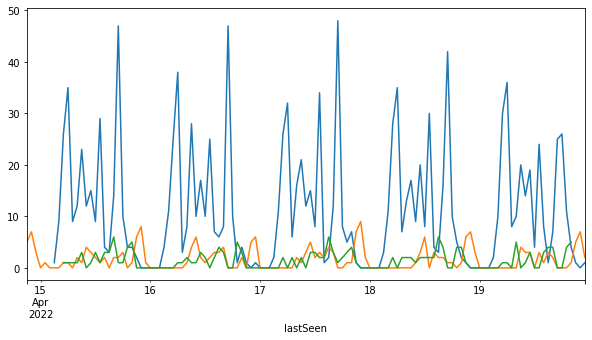

In [14]:
plt.figure(figsize=(10,5))
klm_h.plot();
tra_h.plot();
eju_h.plot();

In [ ]:
carrier_df = arrivals_df.groupby('carrier').count()[['icao24']]

### Amount of arrivals per carrier - top 20 carriers

The graph below shows the amount of arrivals per carrier in the last 7 days. It is clear that KLM has the most arrivals by far. 

In [ ]:
carrier_df.sort_values(by='icao24', ascending=False, inplace=True)
top_20_df = carrier_df[0:20]
plt.figure(figsize=(10,5))
plt.bar(top_20_df.index, top_20_df['icao24'], data=top_20_df);

## Amount of arrivals per carrier per hour. 

In [ ]:
arrivals_df['hours'] = arrivals_df['firstSeen'].dt.hour

In [ ]:
carriers_hours_df = arrivals_df[['carrier','hours','icao24']]

In [ ]:
grouped_df = carriers_hours_df.groupby(['hours', 'carrier']).size().to_frame()

In [ ]:
def get_hourly_per_carrier(carrier):
    carrier_df = carriers_hours_df[carriers_hours_df['carrier']==carrier]
    return carrier_df.groupby('hours').count()['icao24'].to_frame()

### Arrivals per hour

In the below I tried to analyze the amount of arrivals per hour per carrier, in order to see if there are any time slots in which one carrier is privileged above the other carriers. 
Clearly KLM is dominating all carriers in particular during the day. It has most competition between 17:00  and 23:00. Between 19:00 and 20.00 it has to concede in arrivals to Easy Jet and Transavia. This representation is not really good yet because there are many overlapping points.
---


In [ ]:
plt.figure(figsize = (20,10))
for carrier in carrier_df[0:20].index:
    carrier_h = get_hourly_per_carrier(carrier)
    plt.scatter(carrier_h.index, 'icao24', data=carrier_h, label=carrier)

plt.legend(ncol=len(carrier_h.columns))

xminor = np.arange(0, 25, 1)
yminor = np.arange(0, 176, 5)

plt.xticks(xminor)
plt.yticks(yminor)

plt.tick_params(grid_alpha=0.3, which='both')
plt.grid(which='both')


In [ ]:
plt.figure(figsize = (20,10))

for carrier in carrier_df[1:10].index:
    carrier_h = get_hourly_per_carrier(carrier)
    plt.scatter(carrier_h.index, 'icao24', data=carrier_h, label=carrier)

plt.legend(ncol=len(carrier_h.columns))

xminor = np.arange(0, 25, 1)
yminor = np.arange(0, 31, 1)

plt.xticks(xminor)
plt.yticks(yminor)

plt.tick_params(grid_alpha=0.3, which='both')
plt.grid(which='both')

Top 10 Excluding KLM from the dataset gives some interesting insights. Most competition is between Transavia, and EASY Jet, although Delta Airlines (a SkyTeam alliance partner) seems to have control over some of the later slots (between 20:00 and 2:00). This plot needs to be improved as well. 